In [14]:
import pandas as pd
import os, sys

projectdir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(projectdir, 'src'))

from d00_utils.db_utils import dbReadWriteClassification, dbReadWriteViews

In [11]:
io_class = dbReadWriteClassification()
io_class.list_tables()

['evaluations', 'probabilities_frames', 'test1000_for_m1', 'probabilities_frames_test', 'test_probabilities_instances', 'test_probabilities_frames', 'ground_truths', 'test_predictions', 'test1000_for_m2_m3', 'probabilities_instances', 'evaluation', 'predictions']


In [24]:
# df_true = io_class.get_table('ground_truths')

# Load ground truth table instances_w_labels
io_views = dbReadWriteViews()
df_true = io_views.get_table('instances_w_labels')


# Modify instances_w_labels in order to join w/ df_pred
df_true['file_name'] = 'a_' + df_true['studyidk'].map(str) + '_' + df_true['filename']
df_true.drop(columns=['studyidk', 'filename', 'sopinstanceuid', 'instanceidk'], inplace=True)
df_true.rename(columns={'view': 'view_true'}, inplace=True)
print(df_true.shape)
df_true.head()

(25971, 2)


,view_true,file_name
0,plax,a_39531_8Z0BWX0M
1,a4c,a_39531_8Z0BWZGH
2,plax,a_39533_8Z0BXKCB
3,plax,a_39533_8Z0BXYUW
4,plax,a_39552_8ZGVB44R


In [33]:
df_pred = io_class.get_table('predictions')
print(df_pred.shape)
df_pred.tail()

(2072, 9)


,study_id,file_name,model_name,date_run,img_dir,view23_pred,view4_dev,view4_seg,prediction_id
2067,126772,a_126772_FDNHO33T,view_23_e5_class_11-Mar-2018,2019-08-15 15:38:48.380921,/home/ubuntu/data/02_intermediate/test_downsam...,other,other,other,2068
2068,126778,a_126778_FDNHPQ07,model.ckpt-6460,2019-08-15 15:46:05.448335,/home/ubuntu/data/02_intermediate/test_downsam...,plax_plax,plax,plax,2069
2069,126778,a_126778_FDNHPQ07,view_23_e5_class_11-Mar-2018,2019-08-15 15:38:48.380921,/home/ubuntu/data/02_intermediate/test_downsam...,other,other,other,2070
2070,126781,a_126781_FDNHQ1M9,model.ckpt-6460,2019-08-15 15:46:05.448335,/home/ubuntu/data/02_intermediate/test_downsam...,a4c,a4c,a4c,2071
2071,126781,a_126781_FDNHQ1M9,view_23_e5_class_11-Mar-2018,2019-08-15 15:38:48.380921,/home/ubuntu/data/02_intermediate/test_downsam...,a4c,a4c,a4c,2072


In [49]:
# merge tables, drop unnecessary cols
df_merge = df_pred.merge(df_true, on='file_name')
df_merge.drop(columns=['study_id', 'date_run', 'img_dir'], inplace=True)

# add column to see if correct on M1, e.g. dev
df_merge['x_dev'] = df_merge['view4_dev'] == df_merge['view_true']
cols = df_merge.columns.tolist()
#print(cols)
cols_new = cols[-1:]  + cols[-2:-1] + cols[3:5] + cols[2:3] + cols[1:2] + cols[5:6] + cols[0:1]
df_merge = df_merge[cols_new]

# add column to see if correct on M2/M3, e.g. seg
df_merge['x_seg'] = df_merge['view4_seg'] == df_merge['view_true']
cols = df_merge.columns.tolist()
#print(cols)
cols_new = cols[0:1] + cols[-1:] + cols[1:-1]
df_merge = df_merge[cols_new]

print(df_merge.shape)
df_merge.head()

(2072, 9)


,x_dev,x_seg,view_true,view4_dev,view4_seg,view23_pred,model_name,prediction_id,file_name
0,False,False,a4c,plax,plax,plax_plax,model.ckpt-6460,1,a_43763_1LHFYKEZ
1,True,True,a4c,a4c,a4c,a4c,view_23_e5_class_11-Mar-2018,2,a_43763_1LHFYKEZ
2,True,True,plax,plax,plax,plax_plax,model.ckpt-6460,3,a_45076_43IX4IH1
3,True,True,plax,plax,plax,plax_plax,view_23_e5_class_11-Mar-2018,4,a_45076_43IX4IH1
4,True,True,a4c,a4c,a4c,a4c,model.ckpt-6460,5,a_46919_7SQZPLEJ


In [75]:
modz_name = 'view_23_e5_class_11-Mar-2018'
mod0_name = 'model.ckpt-6460'

df = df_merge
df_modz = df[df['model_name'] == modz_name]
df_mod0 = df[df['model_name'] == mod0_name]

print('Accuracy for M1 on zhang, model0')
print(df_modz['x_dev'].value_counts())
print(df_mod0['x_dev'].value_counts())

print('\nAccuracy for M2/M3 on zhang, model0')
print(df_modz['x_seg'].value_counts())
print(df_mod0['x_seg'].value_counts())

Accuracy for M1 on zhang, model0
True     754
False    282
Name: x_dev, dtype: int64
True     1020
False      16
Name: x_dev, dtype: int64

Accuracy for M2/M3 on zhang, model0
False    532
True     504
Name: x_seg, dtype: int64
True     1020
False      16
Name: x_seg, dtype: int64


In [70]:
print(df_mod0['view4_dev'].value_counts())

df = df_mod0
pd.crosstab(df['x_dev'], [df['view_true'], df['view4_dev']])

plax    525
a4c     309
a2c     202
Name: view4_dev, dtype: int64


view_true  a2c       a4c      plax
view4_dev  a2c plax  a4c plax plax
x_dev                             
False        0    9    0    7    0
True       202    0  309    0  509

In [76]:
# df_false = df_mod0[df_mod0['x_dev'] == False]
# df_false.head(20)

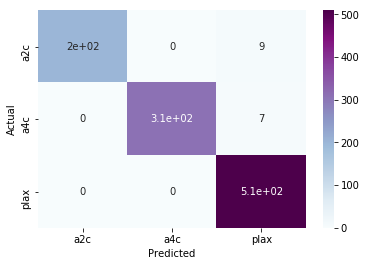

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = pd.Series(df['view_true'].tolist(), name='Actual')
y_pred = pd.Series(df['view4_dev'].tolist(), name='Predicted')
conf_matrix = pd.crosstab(y_true, y_pred)

sns.heatmap(conf_matrix, annot=True, cmap='BuPu')